In [1]:
!ls


sample_data


In [4]:
# donwload scaler
!gdown https://drive.google.com/uc?id=1aWUSGpI1J1DZHvKomtE20bKWiXq3u0Q9
# download db
!gdown https://drive.google.com/uc?id=1bxtMkvkqd9Pib7p22kSbX7r69Yieit1E
# !gdown https://drive.google.com/uc?id=1ZPuNGmHqCV55U-WOUQe45qcGOUTtpWCK
!unzip -q classification_db.zip

Downloading...
From: https://drive.google.com/uc?id=1aWUSGpI1J1DZHvKomtE20bKWiXq3u0Q9
To: /content/scaler.save
100% 1.32k/1.32k [00:00<00:00, 2.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bxtMkvkqd9Pib7p22kSbX7r69Yieit1E
To: /content/classification_db.zip
5.63GB [01:50, 35.3MB/s]


In [5]:
import os
import sys

import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.preprocessing import MinMaxScaler

tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# add src to path
sys.path.insert(0,'/content/gdrive/MyDrive/fake-faces-detector/src/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/fake-faces-detector/src')
from utils.modelling_functions import getYCbCr, get_xception, getAdditionalScalars, get_scalaraNN_model, load_dataset_h5
from utils.db_helper import get_files_paths_recursive


# Loading datasets

In [8]:
import joblib
import skimage
import sklearn

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image as keras_img
from sklearn.utils import shuffle
from PIL import Image

In [24]:
# specify categories
categories = {"fake": 0,
              "real": 1}

# specify learning process
img_input_shape = (299,299,3)
scalars_input_shape = (18,)
batch_size = 16
use_scalars=False

# specify paths
exp_path = f"/content/gdrive/MyDrive/fake-faces-detector/exp/"
train_path = "classification_db/train"
val_path = "/classification_db/val"
saving_dir = os.path.join(exp_path, "models", f"final_model_{use_scalars}")

# directory for saving
if os.path.exists(saving_dir) == False:
    os.makedirs(saving_dir)

In [10]:
scaler = joblib.load(os.path.join(exp_path, "models", "Scaler", "scaler.save"))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
def preprocess_scalars(scalars):
    scalars = np.expand_dims(scalars, axis=0)
    scalars = scaler.transform(scalars)
    scalars = np.squeeze(scalars)
    return scalars

In [12]:
def preprocess_image(img_path):
    pil_image = Image.open(img_path)
    np_image = np.array(pil_image).astype((np.uint8))
    np_image = xception.preprocess_input(np_image)
    np_ycbcr = skimage.color.rgb2ycbcr(np_image)
    
    return np_ycbcr

In [13]:
def generator(path_dir, batch_size, categories, use_scalars=True):
    i = 0

    # get all file paths into proper lists
    if not (os.path.exists(path_dir)):
        raise ValueError("Bad path specified")

    # get all file paths and list with classes
    img_file_list = []
    csv_file_list = []
    class_list = []
    for r, d, f in os.walk(path_dir):
        for file in f:
            if file.endswith(".png"):
                img_file_list.append(os.path.join(r, file))
                class_list.append(os.path.basename(r))
            elif file.endswith(".csv"):
                csv_file_list.append(os.path.join(r, file))

    if not use_scalars:
        csv_file_list = [0] * len(class_list)

    # shuffle all list list together
    img_file_list, csv_file_list, class_list = shuffle(img_file_list, csv_file_list, class_list)
    
    while True:
        batch = {'xception_input': list(), 'dense_input': list(), "labels": list()}  # use a dict for multiple inputs
        for b in range(batch_size):
            # reset iterator number nad shuffle list when all images have been used
            if i == len(img_file_list):
                i = 0
                img_file_list, csv_file_list, class_list = shuffle(img_file_list, csv_file_list, class_list)

            # obtain image path, 
            image_path = img_file_list[i]
            # load and preprocess image
            image = preprocess_image(image_path)
            batch['xception_input'].append(image)

            # if use scalars then load and preprocess them
            if use_scalars:
                scalars = np.array(pd.read_csv(csv_file_list[i], index_col=0, header=None, squeeze=True))
                scalars = preprocess_scalars(scalars)
                batch['dense_input'].append(scalars)

            category_int = categories.get(class_list[i])
            batch['labels'].append(category_int)

            i += 1

        # convert each list to numpy array
        batch['xception_input'] = np.array(batch['xception_input']) 
        batch['dense_input'] = np.array(batch['dense_input'])
        batch['labels'] = np.array(batch['labels'])

        # return value with scalars or without
        if use_scalars:
            yield [batch['xception_input'], batch['dense_input']] , batch['labels']
        else:
            yield batch['xception_input'], batch['labels']


In [57]:
# gen = generator(train_path,32, categories)

In [59]:
# x, y = next(gen)

# Create model

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception, xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Add, Flatten, concatenate
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report


In [15]:
def get_xception():
    base_model = Xception(include_top=False, weights=None, classes=2)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def get_xception_for_double_model():
    input_img = Input(shape=(299, 299,3))

    model = Xception(include_top=False, weights=None, classes=2)(input_img)
    model = GlobalAveragePooling2D()(model)
    # model = Model(inputs=input_img, outputs=model)
    model = Dense(1, activation='sigmoid')(model)
    model = Model(inputs=input_img, outputs=model)

    return model

In [17]:
def get_scalarsNN_model():
    initializer =  tf.keras.initializers.GlorotNormal()
    input_scalar = Input(shape=(18,))
    model = Dense(18, activation='relu', kernel_initializer=initializer)(input_scalar)
    model = Dense(18, activation='relu', kernel_initializer=initializer)(model)
    model = Dense(18, activation='relu', kernel_initializer=initializer)(model)
    model = BatchNormalization()(model)

    model = Dense(10, activation='relu', kernel_initializer=initializer)(model)
    model = Dense(10, activation='relu', kernel_initializer=initializer)(model)
    model = Dense(10, activation='relu', kernel_initializer=initializer)(model)
    model = BatchNormalization()(model)


    model = Dense(5, activation='relu', kernel_initializer=initializer)(model)
    model = Dense(5, activation='relu', kernel_initializer=initializer)(model)
    model = Dense(5, activation='relu', kernel_initializer=initializer)(model)

    model = Model(inputs=input_scalar, outputs=model) 

    return model

In [18]:
if use_scalars:
    # get two models
    model_scalars = get_scalarsNN_model()
    model_cnn = get_xception_for_double_model()

    # # combine them
    combined_model = concatenate([model_scalars.output, model_cnn.output])

    # # create output layes
    model_out = Dense(2, activation='relu')(combined_model)
    model_out = Dense(1, activation='sigmoid')(model_out)

    # # define final model
    model = Model(inputs=[model_cnn.input, model_scalars.input], outputs=model_out)

    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
else:
    model = get_xception()

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkopoint = ModelCheckpoint(os.path.join(saving_dir, "model.h5"),
                              save_best_only=True,
                              save_weights_only=True)

In [78]:
# model.load_weights(os.path.join(saving_dir, "model.h5"))

In [ ]:
results = model.fit(generator(train_path, batch_size, categories, use_scalars=use_scalars),
                    validation_data=generator(val_path, batch_size, categories, use_scalars=use_scalars),
                    callbacks = [early_stop, checkopoint], epochs=10, batch_size=batch_size,
                    steps_per_epoch=2000)

Epoch 1/10
1630/2000 [=======================>......] - ETA: 7:33 - loss: 0.0547 - accuracy: 0.9816

In [19]:
import subprocess as sp
import os

def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  print(memory_free_values)
  return memory_free_values

get_gpu_memory()

[8638]


[8638]

In [20]:

tf.config.experimental.get_memory_info('GPU:0')


{'current': 2225713664, 'peak': 2238753024}

## Evaluation

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import joblib

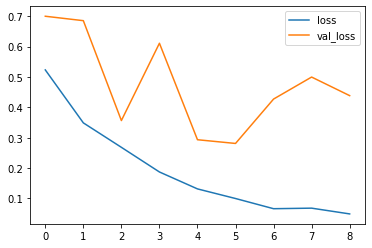

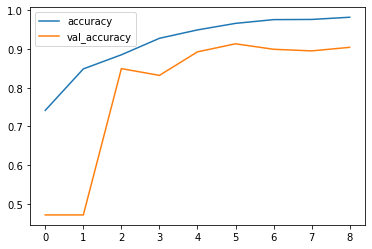

In [ ]:

# # learning history
# losses = pd.DataFrame(model.history.history)
# losses.to_csv(os.path.join(saving_dir, 'losses.csv'))
# # loss plot
# losses[['loss', 'val_loss']].plot()
# plt.savefig(os.path.join(saving_dir, 'loss.png'))
# # acc plot
# losses[['accuracy', 'val_accuracy']].plot()
# plt.savefig(os.path.join(saving_dir, 'acc.png'))
# # model save
# model.save_weights(os.path.join(saving_dir, 'model.h5'))

In [ ]:
y_pred = model.predict(X_val)

y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# version to print
report = classification_report(y_val, y_pred)
print(report)
with open (os.path.join(saving_dir, 'classification_report.txt'), 'w+') as f:
    f.write(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       635
           1       0.91      0.90      0.91       565

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.91      1200
weighted avg       0.91      0.91      0.91      1200



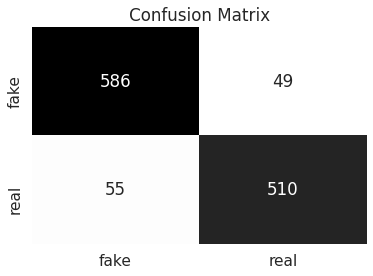

In [ ]:
categories = ["fake", "real"]
# get confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
pd_conf_matrix = pd.DataFrame(conf_matrix, columns=categories, index=categories)
sn.set(font_scale=1.4) # for label size
ax = plt.axes()
sn.heatmap(pd_conf_matrix, ax = ax, annot=True, cmap='binary', fmt='g', cbar = False)
ax.set_title('Confusion Matrix')

plt.savefig(os.path.join(saving_dir, 'conf_matrix.png'))